In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import csv

# Recover Ripple Graph

In [2]:
def recover_links_ases(filename):
    links = set()
    ases = set()
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            l = tuple(row)
            links.add(l)
            ases.add(l[0])
            ases.add(l[1])
    return ases,links

In [3]:
ripple_ases, ripple_links = recover_links_ases('Ripple/gateway_links.csv')

In [4]:
ripple_graph = nx.Graph()
ripple_graph.add_nodes_from(ripple_ases)

In [5]:
print('The Ripple graph contains {} nodes'.format(len(ripple_graph.nodes)))

The Ripple graph contains 15 nodes


# Recover Caida Graph

In [6]:
data = pd.read_csv('Caida/20190301.as-rel2.txt',delimiter='\n', comment='#', header=None, encoding='ISO-8859-1')

data['provider_peer'], data['customer_peer'], data['relation_type'], data['source'] = data[0].str.split('|').str
data['relation_type']  = data['relation_type'].apply(lambda x: 'provider-customer' if x == '-1' else 'peer-peer')
links = data[['provider_peer','customer_peer','relation_type']]

caida_ases = set(links['provider_peer'].values)
caida_ases.update(links['customer_peer'].values)

links['link'] = list(zip(links['provider_peer'], links['customer_peer']))
links = links[['link','relation_type']]
caida_links = {}
for index,row in links.iterrows():
    (s,t) = row['link']
    rel = row['relation_type']
    if rel == 'provider-customer':
        caida_links[tuple([s,t])] = rel
        caida_links[tuple([t,s])] = 'customer-provider'
    else: 
        if rel == 'peer-peer':
            caida_links[tuple([s,t])] = rel
            caida_links[tuple([t,s])] = 'peer-peer'
        else:
            print('Error')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [7]:
caida_graph = nx.Graph()
caida_graph.add_nodes_from(caida_ases)
for k,v in caida_links.items():
    caida_graph.add_edge(k[0],k[1],relation=v)

In [8]:
print('The Caida graph contains {} nodes and {} edges'.format(len(caida_graph.nodes),len(caida_graph.edges)))

The Caida graph contains 64167 nodes and 503651 edges


# Add intermediary nodes to Ripple Graph

In [9]:
for s in ripple_ases:
    for t in ripple_ases:
        paths = nx.all_shortest_paths(caida_graph,s,t)
        for p in paths:
            complete_path = [s] + p
            for i in range(len(complete_path)-1):
                n1 = complete_path[i]
                n2 = complete_path[i+1]
                if(n1 != n2):
                    rel = caida_graph.get_edge_data(n1,n2)['relation']
                    ripple_graph.add_edge(complete_path[i],complete_path[i+1], relation=rel)

In [10]:
print('The Ripple graph contains {} nodes and {} edges'.format(len(ripple_graph.nodes),len(ripple_graph.edges)))

The Ripple graph contains 324 nodes and 1284 edges


In [11]:
nx.set_edge_attributes(ripple_graph, 0, 'weight')

# Replay transactions 

In [12]:
transactions = pd.read_csv('Ripple/transactions_processed.csv', dtype={'sender': str, 'receiver': str, 'amount': np.float64} )
transactions = transactions[['sender','receiver','amount']]

In [13]:
print('Amount of money used in the graph : {}'.format(transactions['amount'].sum()))

Amount of money used in the graph : 95369733.78499946


# Graph Statistics

## Are the gateways directly connected?

In [14]:
for g in ripple_ases:
    neighbors = ripple_graph.neighbors(g)
    for n in neighbors:
        if n in ripple_ases and n != g:
            print('There is a link between {} and {}'.format(n,g))

There is a link between 4766 and 26496
There is a link between 45102 and 19551
There is a link between 13335 and 19551
There is a link between 14618 and 16509
There is a link between 16509 and 14618
There is a link between 19551 and 45102
There is a link between 13335 and 45102
There is a link between 19551 and 13335
There is a link between 45102 and 13335
There is a link between 26496 and 4766


/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


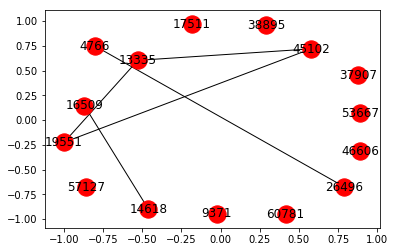

In [15]:
sub = ripple_graph.subgraph(ripple_ases)
nx.draw_networkx(sub)

## How many transactions are affected by a 'direct connection'?

In [16]:
count = 0
amount = 0
for index, row in transactions.iterrows():
    sender = row['sender']
    receiver = row['receiver']
    path = nx.shortest_path(ripple_graph, source=sender, target=receiver)
    if (len(path) == 2):
        count += 1
        amount += row['amount']
        
print('# Transactions affected : {} out of {} - {:.0%}'.format(count, len(transactions), count/len(transactions)))
print('Amount affected : {} out of {} - {:.0%}'.format(amount, transactions['amount'].sum(), amount/transactions['amount'].sum()))

# Transactions affected : 6314 out of 22994 - 27%
Amount affected : 80443866.41520707 out of 95369733.78499946 - 84%


As we can see, only 16% of the total amount can be rerouted since there is no intermediary node

## How many intermediaries are there between each gateways?

### Let's consider the nx algorithm

In [17]:
stats = []
intermediaries = set()
for source in ripple_ases:
    for dest in ripple_ases:
        if(source != dest):
            path = nx.shortest_path(ripple_graph,source,dest)[1:-1]
            intermediaries.update(path)
            
            stats.append(len(path))
            
print('Mean number of intermediaries : {}'.format(np.mean(stats)))
print('Standard deviation of intermediaries : {}'.format(np.std(stats)))
print('There are {} different intermediaries'.format(len(intermediaries)))
print(intermediaries)

Mean number of intermediaries : 1.4952380952380953
Standard deviation of intermediaries : 0.8632586052285455
There are 14 different intermediaries
{'2603', '3356', '6939', '16509', '1299', '2914', '41828', '34779', '7506', '577', '174', '209', '3303', '2906'}


In [18]:
stats = []
intermediaries = set()
for source in ripple_ases:
    for dest in ripple_ases:
        if(source != dest):
            paths = nx.all_shortest_paths(ripple_graph,source,dest)
            for p in paths:
                path = p[1:-1]
                intermediaries.update(path)
                stats.append(len(path))
                
            
print('Mean number of intermediaries : {}'.format(np.mean(stats)))
print('Standard deviation of intermediaries : {}'.format(np.std(stats)))
print('There are {} different intermediaries'.format(len(intermediaries)))
print(intermediaries)

Mean number of intermediaries : 1.6459674365770542
Standard deviation of intermediaries : 0.8319581225988799
There are 310 different intermediaries
{'1103', '40191', '14537', '32653', '31500', '20485', '28260', '8426', '41497', '9381', '1267', '12637', '13030', '6667', '12389', '50877', '4637', '13101', '34288', '31424', '6079', '4775', '8447', '577', '12956', '327960', '4826', '19653', '63927', '5392', '10026', '35369', '21320', '29680', '4739', '56730', '136620', '8222', '205206', '12350', '293', '24441', '3741', '6730', '9050', '2018', '4134', '59605', '9044', '12552', '328320', '18106', '8218', '20764', '209', '9957', '2603', '852', '32354', '6082', '3491', '59689', '3549', '53828', '9902', '21859', '62785', '1798', '64050', '263651', '264268', '62240', '16637', '23473', '20013', '58308', '8283', '49463', '6619', '9318', '42541', '29140', '21232', '14361', '3292', '23352', '1916', '14061', '57724', '28634', '20932', '36351', '2381', '37100', '34019', '64463', '24482', '2119', '1541

### Let's consider the tie-breaker customer > peer > provider

In [19]:
def rel_type(rel):
    if (rel == 'customer-provider'):
        return 2
    if (rel == 'peer-peer'):
        return 1
    if (rel == 'provider-customer'):
        return 0
    return None

In [20]:
def compare_rel(paths, index, ripple_graph):
    best_p = []
    best_rel = 3
    for p in paths:
        start = p[index]
        end = p[index+1]
        rel = rel_type(ripple_graph.get_edge_data(start,end)['relation'])
        if (rel < best_rel):
            best_p = [p]
            best_rel = rel
        elif (rel == best_rel):
            best_p.append(p)
    return best_p

In [21]:
def select_best(source, dest, ripple_graph):
    paths = list(nx.all_shortest_paths(ripple_graph,source,dest))
    ## If only one path, return it
    if(type(paths[0]) == str):
        return paths
    
    ## Assume all paths have same length
    l = len(paths[0])
    temp_paths = paths
    for i in range(0,l-1):
        temp_paths = compare_rel(temp_paths, i, ripple_graph)
    
    if (len(temp_paths) >= 1):
        return temp_paths[0]
    return temp_paths

In [22]:
stats = []
intermediaries = set()
for source in ripple_ases:
    for dest in ripple_ases:
        if(source != dest):
            path = select_best(source,dest,ripple_graph)[1:-1]
            intermediaries.update(path)
            
            stats.append(len(path))
            
print('Mean number of intermediaries : {}'.format(np.mean(stats)))
print('Standard deviation of intermediaries : {}'.format(np.std(stats)))
print('There are {} different intermediaries'.format(len(intermediaries)))
print(intermediaries)

Mean number of intermediaries : 1.4952380952380953
Standard deviation of intermediaries : 0.8632586052285455
There are 24 different intermediaries
{'7506', '577', '174', '7473', '16509', '4826', '1299', '41828', '209', '2906', '2603', '16265', '3267', '852', '2914', '34779', '4637', '3303', '6461', '4739', '4181', '6939', '2828', '1273'}


# Precomputations

In [23]:
best_paths = {}
for source in ripple_graph.nodes:
    for dest in ripple_graph.nodes:
        if(source != dest):
            path = select_best(source,dest,ripple_graph)
            best_paths[(source,dest)] = path

# What if we remove one node?

## Consider tie-breaker customer > peer > provider

In [24]:
def replay_transactions_remove(transactions, corrupted_graph, complete_graph):
    amount_ok = 0
    amount_lost = 0
    amount_rerouted = 0
        
    for index, row in transactions.iterrows():
        sender = row['sender']
        receiver = row['receiver']
        try :
            amount = row['amount']
            path_corrupted = select_best(sender,receiver,corrupted_graph)
            
            #path_ok = select_best(list(nx.all_shortest_paths(complete_graph,sender,receiver)))
            path_ok = best_paths[(sender,receiver)]
            if (path_corrupted == path_ok):
                amount_ok += amount
            else:
                amount_rerouted += amount
        except:
            #print('No path between {} and {}'.format(sender,receiver))
            amount_lost += amount
    return amount_ok, amount_lost, amount_rerouted

In [25]:
#df_corrupted = pd.DataFrame(columns=['corrupted', 'amount_ok', 'amount_lost', 'amount_rerouted'])

In [27]:
#for c in ripple_graph.nodes:
#    corrupted_graph = ripple_graph.copy()
#    corrupted_graph.remove_node(c)
#    amount_ok, amount_lost, amount_rerouted = replay_transactions_remove(transactions, corrupted_graph, ripple_graph)
#    df_corrupted = df_corrupted.append({'corrupted': c, 'amount_ok': amount_ok, 'amount_lost': amount_lost, 'amount_rerouted': amount_rerouted}, ignore_index=True)

In [28]:
#df_corrupted.set_index('corrupted').to_csv('statistics_remove_cpp.csv')

In [29]:
df_corrupted = pd.read_csv('statistics_remove_cpp.csv', index_col='corrupted')

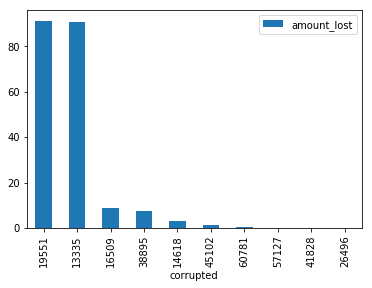

In [30]:
df_corrupted['amount_lost'].apply(lambda x: x*100/transactions['amount'].sum()).sort_values(ascending=False).head(10).to_frame().plot.bar()

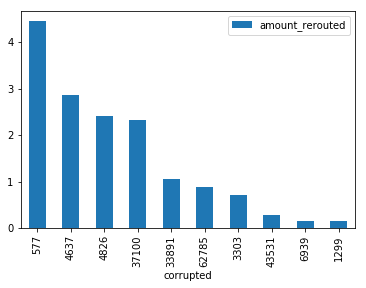

In [31]:
df_corrupted['amount_rerouted'].apply(lambda x: x*100/transactions['amount'].sum()).sort_values(ascending=False).head(10).to_frame().plot.bar()

# What if there is BGP hijacking?

In [32]:
def replay_transactions_hijack(transactions, corrupted_node, complete_graph):
    amount_ok = 0
    amount_lost = 0
    amount_rerouted = 0
    for index, row in transactions.iterrows():
        sender = row['sender']
        receiver = row['receiver']
        
        if(corrupted_node != sender and corrupted_node != receiver):
            try :
                amount = row['amount']
                #path_ok = select_best(list(nx.all_shortest_paths(complete_graph,sender,receiver)))
                path_ok = best_paths[(sender,receiver)]

                #path_to_corrupted = select_best(list(nx.all_shortest_paths(complete_graph, sender, corrupted_node)))
                #path_from_corrupted = select_best(list(nx.all_shortest_paths(complete_graph, corrupted_node, receiver)))
                path_corrupted = best_paths[(sender, corrupted_node)]
                
                if (len(path_corrupted) + 1 > len(path_ok)):
                    amount_ok += amount
                else:
                    amount_rerouted += amount
            except:
                #print('No path between {} and {}'.format(sender,receiver))
                amount_lost += amount
    return amount_ok, amount_lost, amount_rerouted

In [33]:
df_corrupted = pd.DataFrame(columns=['corrupted', 'amount_ok', 'amount_lost', 'amount_rerouted'])

In [34]:
for c in ripple_graph.nodes:
    amount_ok, amount_lost, amount_rerouted = replay_transactions_hijack(transactions, c, ripple_graph)
    df_corrupted = df_corrupted.append({'corrupted': c, 'amount_ok': amount_ok, 'amount_lost': amount_lost, 'amount_rerouted': amount_rerouted}, ignore_index=True)

In [35]:
df_corrupted.set_index('corrupted').to_csv('statistics_hijack_cpp.csv')

In [36]:
df_corrupted = pd.read_csv('statistics_hijack_cpp.csv', index_col='corrupted')

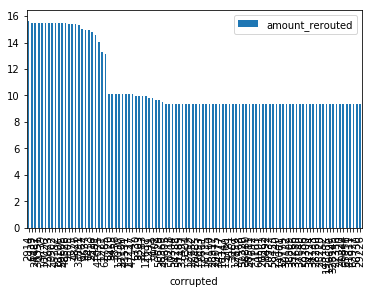

In [37]:
df_corrupted['amount_rerouted'].apply(lambda x: x*100/transactions['amount'].sum()).sort_values(ascending=False).head(100).to_frame().plot.bar()